# What if in Python

# 12.5 : Mô hình cấu trúc biên có hiệp biến

### BS. Lê Ngọc Khả Nhi


# Giới thiệu

"What if" hay "The Causal Inference book" của Jamie Robins và Miguel Hernan là một tác phẩm rất hay và có thể dùng như một giáo trình về chuyên đề Suy luận nhân quả. Trong bài này Nhi sử dụng ngôn ngữ Python để minh họa cho Chương 12. Nhi có tham khảo code của James Fiedler https://github.com/jrfiedler/causal_inference_python_code ; với một số thay đổi, thí dụ dùng lập trình hàm thay vì code thủ công và dùng nhiều biểu đồ hơn.

# Mô hình MSM có chứa hiệp biến

Trong bài trước, Nhi đã minh họa mục 12.4 về mô hình cấu trúc biên (Marginal structural model, MSM). MSM là một mô hình tuyến tính được khớp trên dữ liệu quần thể ảo (bằng trọng số nghịch đảo xác suất ổn định, SIPW), cho phép ước lượng hiệu ứng nhân quả trung bình của can thiệp A (thí dụ bỏ hút thuốc) đối với kết quả Y (thí dụ thay đổi cân nặng).

Tuy nhiên, mô hình MSM bài trước chỉ xét duy nhất yếu tố can thiệp A vì mục tiêu của nó đơn giản nhắm đến hiệu ứng trung bình của A trong quần thể, nhưng không xét đến hiệu ứng của các hiệp biến (lưu ý: khái niệm hiệp biến này là tổng quát, nó có thể bao gồm cả những yếu tố gây nhiễu (confounders) hoặc hiệp biến không gây nhiễu (non-confounders)).

Đôi khi, ta cần khảo sát giả thuyết về vai trò của một hiệp biến V (thí dụ Giới tính) có khả năng làm thay đổi hiệu ứng của can thiệp A (Bỏ hút thuốc) - tương ứng với câu hỏi: hiệu quả của việc bỏ hút thuốc đối với cân nặng có khác nhau giữa Nam giới và nữ giới hay không ?

Để giải quyết bài toán này, ta sẽ đưa thêm hiệp biến V vào mô hình MSM như sau:

$$E\left [ Y^{a}|V \right ] = \beta_{0} + \beta_{1}a + \beta_{2}V.a + \beta_{3}V $$

Bạn có thấy mô hình này quen không ? Đây chính là mô hình tuyến tính thường dùng để khảo sát hiệu ứng tương tác giữa 2 hiệp biến V và A, nếu hiệu ứng tương tác $V*A$ là có thực, giá trị của hệ số hồi quy $\beta_{2}$ sẽ khác 0; 

Tuy về bản chất, đây không còn là mô hình cấu trúc biên nữa, vì nó đã được điều kiện hóa theo V, nhưng do kỹ thuật phân tích không có gì thay đổi, ta vẫn dùng thuật ngữ MSM.

Lưu ý là ta chỉ suy diễn thống kê cho riêng $\beta_{2}$, nhưng không suy diễn $\beta_{3}$ như hiệu ứng nhân quả của yếu tố giới tính V, theo cách ta đã làm cho $\beta_{1}$ của can thiệp A. 

Ta có thể ước tính các tham số của mô hình bằng cách khớp một mô hình hồi quy tuyến tính sau:

$$E\left [ Y|A,V \right ] = \theta_{0} + \theta_{1}A + \theta_{2}V.A + \theta_{3}V $$

bằng phương pháp bình phương nhỏ nhất có áp dụng trọng số xác suất nghịch đảo $W^{A}$ hoặc trọng số xác suất nghịch đảo ổn định $SW^{A}$


$$SW^{A}\left ( V \right ) = \frac{f\left [A|V\right]}{f\left [A|L\right]}$$

Vectơ tập hợp hiệp biến $L$ cần bao gồm $V$, ngay cả khi $V$ không phải là yếu tố gây nhiễu và bất kỳ biến nào khác cần thiết để đảm bảo giả định về khả năng trao đổi (exchangeability) giữa các mức giá trị của $V$.

Như ta thấy, cả tử số và mẫu số của công thức tính $SW^{A}\left ( V \right )$ đều chứa hiệp biến V, theo tác giả cho biết, cách làm này sẽ thu hẹp mức độ phân tán của kết quả các hiệu ứng cần khảo sát.

Ta sẽ ước tính $SW^{A}\left ( V \right )$ theo cách làm tương tự như đối với SWA trong mục 12.2, ngoại trừ việc đưa thêm hiệp biến $V$ vào mô hình logistic cho tử số.


# Thí nghiệm để tái hiện kết quả phân đoạn 12.5

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Dataframe và random

import numpy as np
import pandas as pd

# Stats
import scipy

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns

# GLM
from patsy import dmatrices
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.regression._prediction import get_prediction

Ta trở lại với thí dụ minh họa dùng trong sách. Như 2 bài trước, ta dùng bộ dữ liệu National Health and Nutrition Examination Survey (NHEFS).

Các bạn tải dữ liệu từ đây:
https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2017/01/nhefs_excel.zip

Sau khi tải về, các bạn giải nén để có file excel: NHEFS.xls, đặt file này vào cùng thư mục với notebook để làm thí nghiệm.

Nhắc lại về bối cảnh của bài toán, ta thực hiện nghiên cứu nhằm xác minh liệu bỏ hút thuốc lá có gây thay đổi tích cực về cân nặng trong thời gian 10 năm hay không ? Trong dữ liệu ta có biến kết quả là wt82_71 chỉ giá trị thay đổi cân nặng giữa năm 1982 và 1971, và một số biến khác có vai trò can thiệp nhị phân, can thiệp định lương hay confounders.

Như những bài trước, Nhi viết 1 hàm quick_data_prep để chuẩn bị dữ liệu cho thí nghiệm:

In [2]:
def quick_data_prep(file_name: str, intensity_filter = False) -> pd.DataFrame :
    
    df = pd.read_excel(file_name)
    
    check_cols = ['sex', 'age', 'race', 'wt82', 
             'ht', 'school', 'alcoholpy', 
             'smokeintensity']

    na_mask = df[check_cols].isna().any(axis=1)
    df_1 = df.loc[~na_mask]
    
    for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
        df_1[f'{col}_2'] = df_1[col] ** 2
        
    df2 = pd.concat([df_1] + [pd.get_dummies(df_1[col], prefix = col[:3])
                 for col in ['education','exercise','active']],
                    axis = 1)
    
    if intensity_filter:
        sub_df = df2.loc[df2.smokeintensity <= 25]
    else:
        sub_df = df2.copy()
    
    cols = ['wt82_71',
            'qsmk',
            'smkintensity82_71',
            'sex','race',
            'edu_2','edu_3','edu_4','edu_5',
            'exe_1','exe_2',
            'act_1','act_2',
            'age','age_2',
            'wt71','wt71_2',
            'smokeintensity','smokeintensity_2',
            'smokeyrs','smokeyrs_2','seqn']
    
    sub_df = sub_df[cols]
    
    sub_df.reset_index(inplace = True, drop =True)
        
    return sub_df

Áp dụng hàm này, ta sẽ có dataframe sub_df gốm 1566 hàng

In [4]:
sub_df = quick_data_prep('NHEFS.xls')

sub_df

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,wt82_71,qsmk,smkintensity82_71,sex,race,edu_2,edu_3,edu_4,edu_5,exe_1,...,act_2,age,age_2,wt71,wt71_2,smokeintensity,smokeintensity_2,smokeyrs,smokeyrs_2,seqn
0,-10.093960,0,-10,0,1,0,0,0,0,0,...,0,42,1764,79.04,6247.3216,30,900,29,841,233
1,2.604970,0,-10,0,0,1,0,0,0,0,...,0,36,1296,58.63,3437.4769,20,400,24,576,235
2,9.414486,0,-14,1,1,1,0,0,0,0,...,0,56,3136,56.81,3227.3761,20,400,26,676,244
3,4.990117,0,4,0,1,0,0,0,0,0,...,0,68,4624,59.42,3530.7364,3,9,53,2809,245
4,4.989251,0,0,0,0,1,0,0,0,1,...,0,40,1600,87.09,7584.6681,20,400,19,361,252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,8.500028,0,0,1,0,0,0,0,0,0,...,0,47,2209,84.94,7214.8036,20,400,31,961,25013
1562,1.360117,0,0,0,0,0,0,0,0,0,...,0,45,2025,63.05,3975.3025,40,1600,29,841,25014
1563,3.514970,0,0,1,0,0,0,0,0,0,...,0,47,2209,57.72,3331.5984,20,400,31,961,25016
1564,4.762639,0,5,0,0,0,0,0,0,1,...,0,68,4624,52.39,2744.7121,15,225,46,2116,25032


Nhi vẽ biểu đồ hộp để khảo sát phân bố của sự thay đổi cân nặng sau 10 năm (biến kết quả) giữa 4 phân nhóm sinh ra từ tổ hợp giữa 2 biến nhị phân: Bỏ hút thuốc và Giới tính:

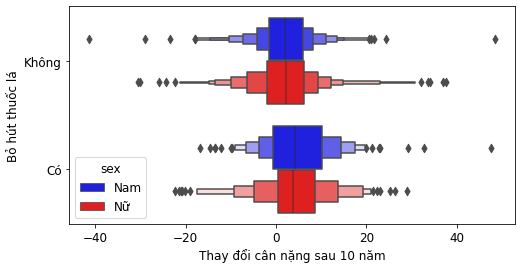

In [8]:
def interaction_plot(df = None):
    
    temp_df = df[['qsmk','sex','wt82_71']].copy()
    
    temp_df['sex'] = temp_df['sex'].map({1 : 'Nữ', 0: 'Nam'})
    temp_df['qsmk'] = temp_df['qsmk'].map({0 : 'Không', 1: 'Có'})
    
    plt.rcParams["figure.figsize"] = (8,4)
    plt.rcParams.update({'font.size': 12})
    
    sns.boxenplot(data=temp_df, 
                  y="qsmk", 
                  x="wt82_71", 
                  hue="sex",
                  dodge=True,
                  palette = ['blue','red'])
    
    plt.ylabel('Bỏ hút thuốc lá')
    plt.xlabel('Thay đổi cân nặng sau 10 năm')
    plt.show()

interaction_plot(sub_df)

In [26]:
sub_df.groupby(['sex','qsmk'])['wt82_71'].describe(percentiles = [0.05,0.95])

count      mean       std        min         5%       50%  \
sex qsmk                                                              
0   0     542.0  2.001335  6.880498 -41.280470  -8.381013  2.041582   
    1     220.0  4.832318  8.487557 -16.778813  -7.386802  4.194149   
1   0     621.0  1.969802  7.917519 -30.501922 -10.777157  2.263034   
    1     183.0  4.155721  9.061361 -22.230470 -10.780436  3.854779   

                95%        max  
sex qsmk                        
0   0     12.015796  48.538386  
    1     18.372549  47.511303  
1   0     13.044588  37.650512  
    1     20.135427  28.912550

Để ước tính trọng số $SW^{A}\left ( V \right )$ và tạo ra quần thể ảo, ta cần 1 hàm để tính propensity score, hay xác suất can thiệp bỏ thuốc lá (A = 1). Hàm này sẽ được dùng 2 lần cho tử số $f\left [A|V\right]$ (A = 1 tùy thuộc vào hiệp biến V và mẫu số $f\left [A|L\right]$ (A = 1 điều kiện hóa theo tập hợp confounders  L - bao gồm cả V).

In [10]:
def propensity(y: pd.Series, 
               X: pd.DataFrame):
    """
    Tính propensity score hay f(y|X)
    sừ dụng hồi quy logistic
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    propensity score: Numpy array
    """
    y = np.asarray(y).flatten()
    mod = sm.Logit(endog = y, 
                   exog = X).fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = mod.predict(X.loc[y == 1])
    weights[y == 0] = (1 - mod.predict(X.loc[y == 0]))
    
    return weights

Tiếp theo, Nhi viết hàm SW_AV để tính trọng số $SW^{A}\left ( V \right)$, hàm này nhận 2 công thức cho 2 mô hình logistic của tử số (numer_form) và mẫu số (denom_form), và dataframe dữ liệu

In [11]:
def SW_AV(numer_form: str, 
          denom_form: str,
          data: pd.DataFrame):
    
    # Tử số f(A|V) (propensity score) bằng 1 mô hình logistic
    y,X_1 = dmatrices(numer_form,  
                      data=data,
                      return_type='dataframe')
    
    numer = propensity(y, X_1)
    
    # Mẫu số f(A|L)
    y,X_2 = dmatrices(denom_form,  
                      data=data,
                      return_type='dataframe')
    
    denom = propensity(y, X_2)
    weights = 1 / denom
    
    sw_AV = numer * weights
    
    return sw_AV

Thi hành hàm này, ta sẽ có kết quả của $SW^{A}\left ( V \right)$

In [17]:
sw_AV = SW_AV(data = sub_df,
              numer_form = 'qsmk ~ sex',
              denom_form = 'qsmk ~ 1 + sex + race + \
              edu_2 + edu_3 + edu_4 + edu_5 + \
              exe_1 + exe_2 + \
              act_1 + act_2 + \
              age + age_2 + \
              wt71 + wt71_2 + \
              smokeintensity + smokeintensity_2 + \
              smokeyrs + smokeyrs_2'
              )

Optimization terminated successfully.
         Current function value: 0.567819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6


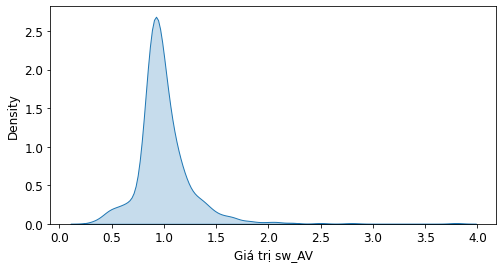

In [22]:
sns.kdeplot(sw_AV, shade = True)
plt.xlabel('Giá trị sw_AV')

plt.show()

Sau cùng, Nhi viết hàm msm_cov_inference để dựng mô hình MSM có hiệp biến và suy diễn thống kê cho mô hình này. hàm này nhận công thức 'wt82_71 ~ qsmk * sex' như một mô hình GLM có yếu tố tương tác, chuỗi trọng số sw_AV, và grp là mã số định danh của các đối tượng (cột seqn).

In [23]:
def msm_cov_inference(form: str,
                      data: pd.DataFrame,
                      sw_AV: np.array,
                      grp: str):
    
    y,X = dmatrices(form,  
                    data=data,
                    return_type='dataframe')
    
    y = np.asarray(y).flatten()
    
    model = sm.WLS(endog = y,
                   exog = X,
                   weights = sw_AV)
    
    res = model.fit(cov_type='cluster', 
                    cov_kwds={'groups': data[grp]})
    
    return res.summary().tables[1]

Sau đây là kết quả mô hình:

In [24]:
msm_cov_inference(data = sub_df,
                  form = 'wt82_71 ~ qsmk * sex',
                  sw_AV = sw_AV,
                  grp = 'seqn')

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.7844,0.310,5.752,0.000,1.176,2.393
qsmk,3.5220,0.658,5.353,0.000,2.232,4.811
sex,-0.0087,0.449,-0.019,0.985,-0.890,0.872
qsmk:sex,-0.1595,1.047,-0.152,0.879,-2.212,1.893


Theo kết quả này, ta không tìm thấy bằng chứng nào về hiệu ứng tương tác giữa can thiệp và giới tính, vì khoảng tin cậy 95% ước tính cho tham số theta2 là -2.21 đến 1.89, có chứa giá trị 0.

Như vậy, kinh nghiệm rút ra đó là thay vì tốn công sức thực hiện cả một quy trình phức tạp như thế này, điều tra viên cần có cơ sở vững chắc cho giả thuyết về hiệu ứng của hiệp biến V trước khi đưa V vào mô hình MSM, hoặc điều tra viên thực sự quan tâm nhiều đến việc khảo sát hiệu ứng can thiệp cho từng phân nhóm riêng biệt của V.

Nếu điều tra viên tham lam, đưa toàn bộ các counfounders và hiệp biến vào mô hình, lúc này V cũng chính là L, nên giá trị SW_AV sẽ = 1 (tử số = mẫu số), việc dùng MSM hoàn toàn vô nghĩa trong trường hợp này.

Một chi tiết thú vị khác của mô hình MSM chứa trọng số, đó là thông qua mô hình này, ta có thể phân biệt được 2 khái niệm khác nhau : tác động gây nhiễu (counfounding effect) và sự điều chỉnh hiệu ứng can thiệp (modification/moderation of treatment effect), có thể song song tồn tại nếu V vừa là counfounder, vừa là moderator. Thực vậy: Công đoạn khử nhiễu bằng IPW trở nên độc lập với suy diễn về sự điều chỉnh hiệu ứng can thiệp trong mô hình MSM.

Một ứng dụng khác của mô hình MSM có hiệp biến, đó là khi ta muốn suy luận nhân quả cho đồng thời 2 can thiệp điều trị A & B, lúc này ta sẽ đưa cả A và B vào mô hình MSM như 2 hiệp biến, và khảo sát tham số cho cả hiệu ứng A,B và tương tác giữa chúng.

Bài thực hành đến đây là hết, tạm biệt các bạn.